## Supply Less than the Demand

In [43]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd
from itertools import combinations

In [44]:
df1 = pd.DataFrame({'node':['Cleveland','Bedford','York','Boston','Chicago','St.Louis','Lexington'],
                                     'demand':[-5000,-6000,-2500,2000,4000,2000,1500]})
df1

,node,demand
0,Cleveland,-5000
1,Bedford,-6000
2,York,-2500
3,Boston,2000
4,Chicago,4000
5,St.Louis,2000
6,Lexington,1500


In [45]:
if df1['demand'].sum() !=0:
    df1.loc[df1.shape[0]+1,'demand']=-(df1['demand'].sum())
    df1.loc[df1.shape[0],'node']='dummy'
df1

,node,demand
0,Cleveland,-5000.0
1,Bedford,-6000.0
2,York,-2500.0
3,Boston,2000.0
4,Chicago,4000.0
5,St.Louis,2000.0
6,Lexington,1500.0
8,dummy,4000.0


In [46]:
# If 'dummy' is negative
if df1[df1['node'] == 'dummy']['demand'].values[0] < 0:
    # Create the DataFrame for positive values
    dummy_df = df1[df1['demand'] > 0].copy()
    dummy_df['source'] = 'dummy'
    dummy_df['cost'] = 0
    dummy_df = dummy_df.rename(columns={'node': 'destination'})
    dummy_df=dummy_df.drop('demand',axis=1)
else:
    # Create the DataFrame for negative values
    dummy_df = df1[df1['demand'] < 0].copy()
    dummy_df['destination'] = 'dummy'
    dummy_df['cost'] = 0
    dummy_df = dummy_df.rename(columns={'node': 'source'})
    dummy_df=dummy_df.drop('demand',axis=1)

In [47]:
df2 = pd.DataFrame({
    'source':['Cleveland','Cleveland','Cleveland','Cleveland','Bedford','Bedford','Bedford','Bedford','York','York','York','York'],
    'destination':['Boston','Chicago','St.Louis','Lexington','Boston','Chicago','St.Louis','Lexington','Boston','Chicago','St.Louis','Lexington'],
    'cost':[3,2,7,6,7,5,2,3,2,5,4,5]})
df2=pd.concat([df2,dummy_df])
#pd.merge(left=df2,right=df1,how='left',left_on='source',right_on='source_node')
df2

,source,destination,cost
0,Cleveland,Boston,3
1,Cleveland,Chicago,2
2,Cleveland,St.Louis,7
3,Cleveland,Lexington,6
4,Bedford,Boston,7
5,Bedford,Chicago,5
6,Bedford,St.Louis,2
7,Bedford,Lexington,3
8,York,Boston,2
9,York,Chicago,5


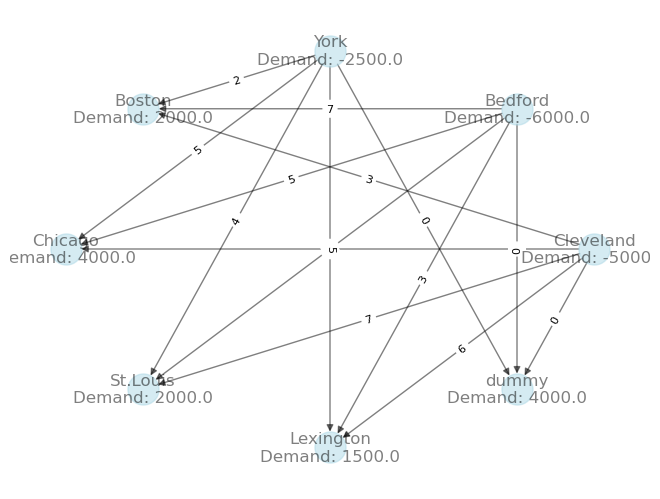

In [48]:
import networkx as nx
import matplotlib.pyplot as plt
import pandas as pd


# Create a directed graph (DiGraph)
G = nx.DiGraph()

# Add nodes with demand as node attribute
for _, row in df1.iterrows():
    G.add_node(row['node'], demand=row['demand'])

# Add edges with weights (costs)
for _, row in df2.iterrows():
    G.add_edge(row['source'], row['destination'], weight=row['cost'])

# Create a layout for the nodes
pos = nx.circular_layout(G)

# Draw the nodes with labels (including demand values)
node_labels = {node: f"{node}\nDemand: {G.nodes[node]['demand']}" for node in G.nodes()}
nx.draw(G, pos, with_labels=True, labels=node_labels, node_size=500, node_color='lightblue',alpha=0.5)

# Draw the edges with weights as labels
edge_labels = {(edge[0], edge[1]): G[edge[0]][edge[1]]['weight'] for edge in G.edges()}
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=8)

# Show the graph
plt.show()

In [49]:
G = nx.DiGraph()
# Add nodes with demands
for _, row in df1.iterrows():
    
    G.add_node(row['node'], demand=row['demand'])

# Add edges with weights (costs)
for _, row in df2.iterrows():
    G.add_edge(row['source'], row['destination'], weight=row['cost'])
flowCost,flowDict = nx.network_simplex(G)
print(flowDict)
print(flowCost)

{'Cleveland': {'Boston': 0.0, 'Chicago': 4000.0, 'St.Louis': 0, 'Lexington': 0, 'dummy': 1000.0}, 'Bedford': {'Boston': 0, 'Chicago': 0, 'St.Louis': 2000.0, 'Lexington': 1500.0, 'dummy': 2500.0}, 'York': {'Boston': 2000.0, 'Chicago': 0, 'St.Louis': 0, 'Lexington': 0.0, 'dummy': 500.0}, 'Boston': {}, 'Chicago': {}, 'St.Louis': {}, 'Lexington': {}, 'dummy': {}}
20500.0


In [50]:
import pandas as pd

# Convert the flowDict dictionary to a DataFrame
df = pd.DataFrame.from_dict(flowDict, orient='index').fillna(0)

# Reset the index to have 'source' as a column
df.reset_index(inplace=True)
df.rename(columns={'index': 'source'}, inplace=True)

# Melt the DataFrame to have 'source', 'destination', and 'flow' columns
df_melted = pd.melt(df, id_vars='source', var_name='destination', value_name='flow')
df_melted=df_melted[df_melted['flow']!=0]
df_melted=pd.merge(left=df_melted,right=df2,how='inner',on=['source','destination'])
df_melted['TotCost']=df_melted['flow']*df_melted['cost']
df_melted

,source,destination,flow,cost,TotCost
0,York,Boston,2000.0,2,4000.0
1,Cleveland,Chicago,4000.0,2,8000.0
2,Bedford,St.Louis,2000.0,2,4000.0
3,Bedford,Lexington,1500.0,3,4500.0
4,Cleveland,dummy,1000.0,0,0.0
5,Bedford,dummy,2500.0,0,0.0
6,York,dummy,500.0,0,0.0


In [51]:
df_melted['TotCost'].sum()

20500.0

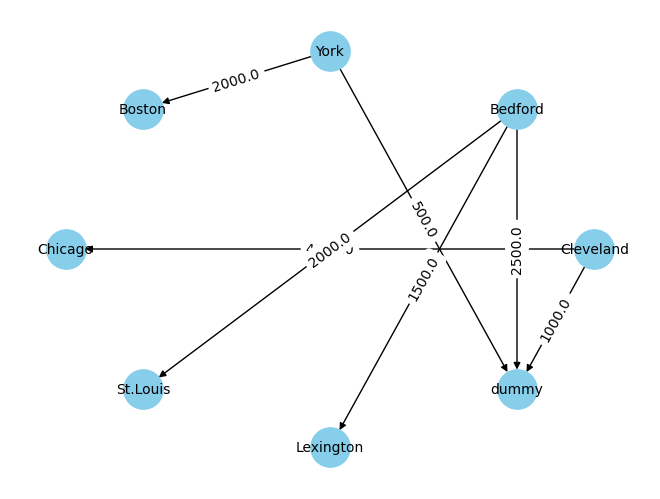

In [52]:
# Create an empty directed graph
G = nx.DiGraph()

# Add nodes to the graph
nodes = flowDict.keys()
G.add_nodes_from(nodes)

# Add edges with non-zero values
for source, destinations in flowDict.items():
    for destination, value in destinations.items():
        if value != 0:
            G.add_edge(source, destination, weight=value)

# Draw the graph
pos = nx.circular_layout(G)  # You can choose a different layout if you prefer
edge_labels = {(u, v): G[u][v]['weight'] for u, v in G.edges()}

nx.draw(G, pos, with_labels=True, node_size=800, node_color='skyblue', font_size=10, font_color='black')
nx.draw_networkx_edge_labels(G, pos, edge_labels=edge_labels, font_size=10)

plt.show()

In [53]:
# In the final analysis we can ignore the values assigned to dummy variables